# Mapping Survival Probability to Channel Density

Loading BokehJS ...


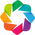

In [1]:
import numpy as np
import pandas as pd
import mscl_utils as mscl
import bokeh.io
import bokeh.plotting
import holoviews as hv 
import theano.tensor as tt
from tqdm import tqdm_notebook, tqdm
import bebi103
import pymc3 as pm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
mscl.set_plotting_style()
bokeh.io.output_notebook()
sns.set_palette('deep', color_codes=True)
hv.extension('bokeh')

In [2]:
# Load the two datasets
cal_data = pd.read_csv('../data/csv/compiled_calibration_data.csv')
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Make one dataframe containing the same axes.
cal_keys = cal_data.keys()
shock_keys = shock_data.keys()
for key in shock_keys:
    if key not in cal_keys:
        shock_data.drop(key, axis=1, inplace=True)

# Make a single dataframe
cal_data.insert(0, 'data_set', 'calibration')
shock_data.insert(0, 'data_set', 'shock')
data = pd.concat([cal_data, shock_data], ignore_index=True)

# Prune the data to values always greater than zero & ignore 10sd1
data = data[(data['rescaled_intensity'] >= 0) & (data['rbs'] != '10sd1')]

# Adjust the rescaled intensity to account for exposure. 
frac_exp = data['exposure_ms'].max() / data['exposure_ms']
data['rescaled_intensity'] = (data['intensity'] - data['mean_bg']) * frac_exp


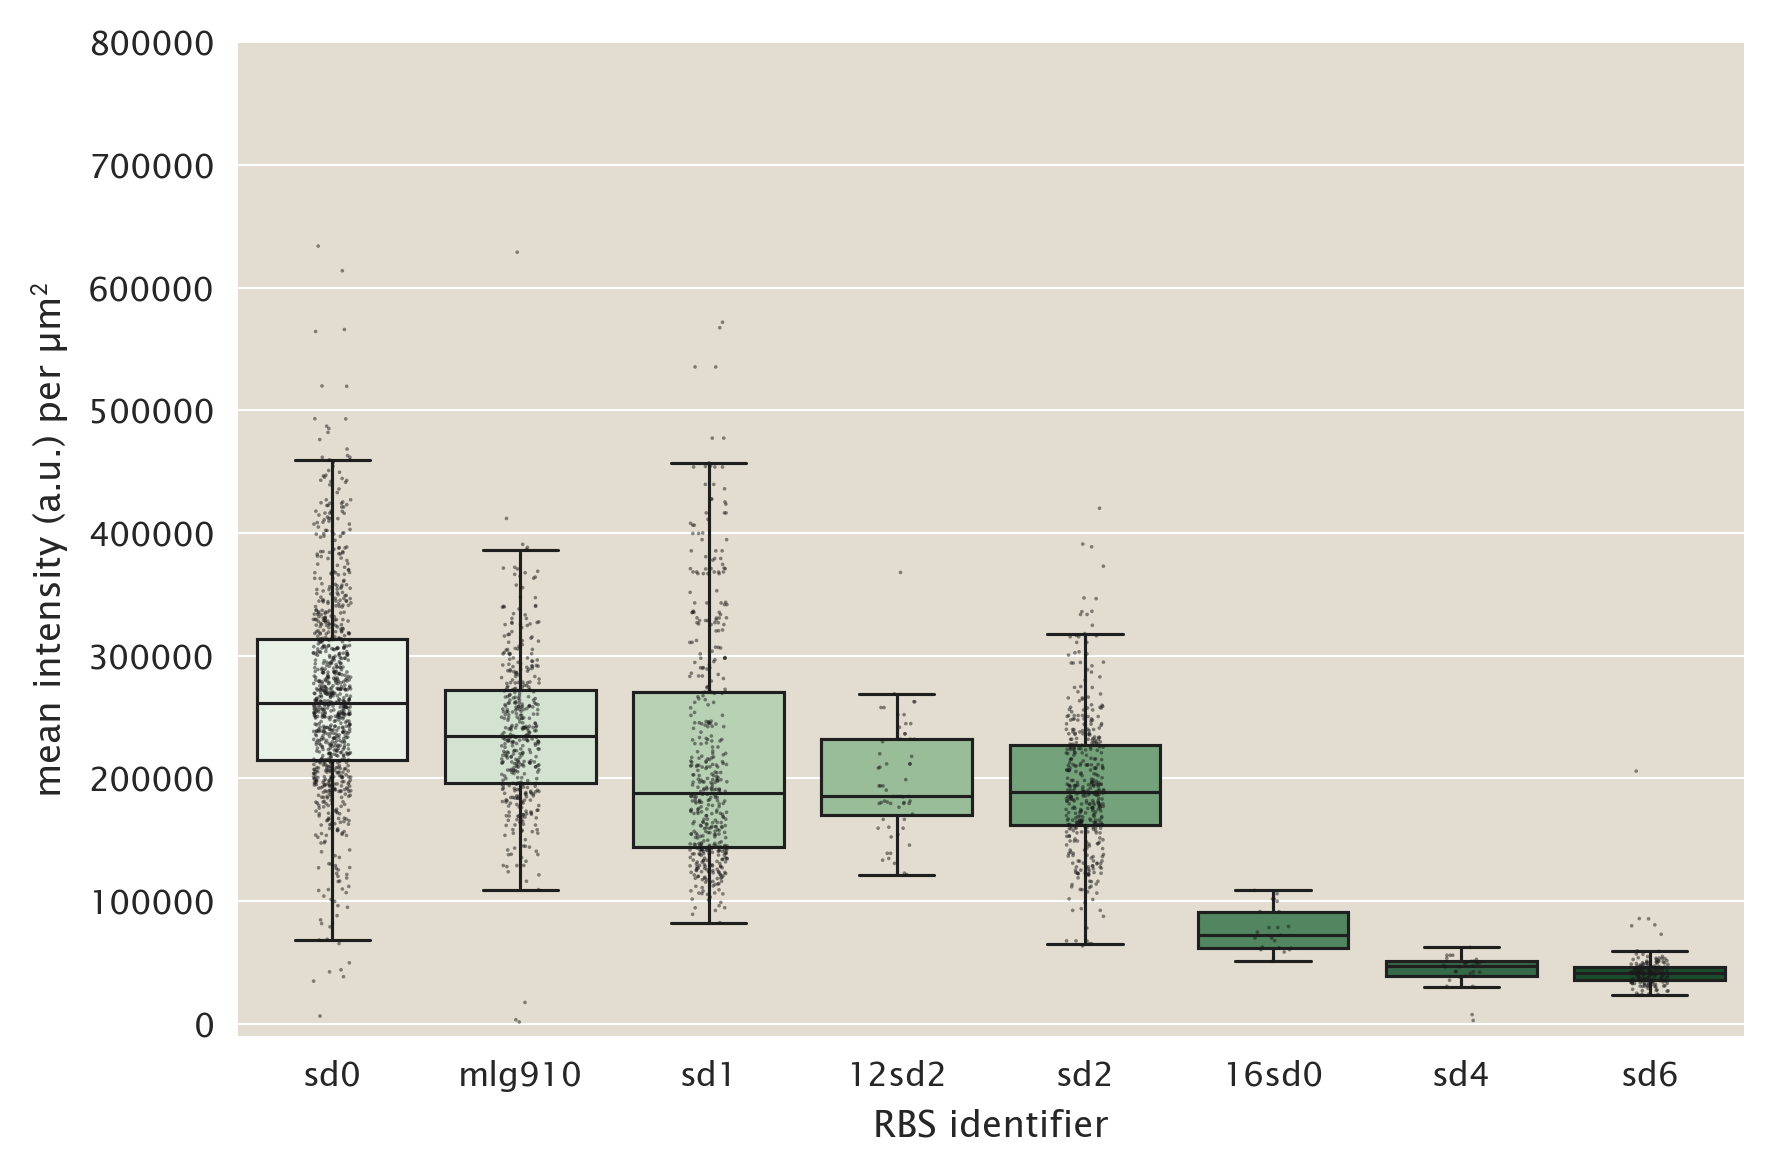

In [545]:
# Rank order the strains by expression.
order = data.groupby('rbs')['rescaled_intensity'].mean().sort_values()[::-1].index

# Set up the figure axis.
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# Plot the box-whiskers and the jitter plot.
_ = sns.boxplot(x='rbs', y='rescaled_intensity', data=data, palette='Greens', order=order,
           linewidth=0.75, ax=ax, fliersize=0, saturation=0.5, )
_ = sns.stripplot(x='rbs', y='rescaled_intensity', data=data, order=order,
            jitter=True, alpha=0.5, marker='.', size=1.75, color='k') 

# Add an indicator to the standard candle.
ax.set_ylim([-10000, 8E5])
# ax.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], color='#FFEDC0', lw=35, alpha=0.75, zorder=0)
# fig.text(0.21, 0.915, '$N$ = 340 ± 68 / cell', fontsize=8, backgroundcolor='#FFEDC0',
#         alpha=0.75)
# Add labels, format, and save the plot
ax.set_xlabel('RBS identifier')
ax.set_ylabel('mean intensity (a.u.) per µm$^2$')
plt.tight_layout()
plt.savefig('../figs/analysis/rbs_expression_boxplots_no_highlight.pdf', bbox_inches='tight')

In [546]:
# Convert based off of our standard candle. 
CHANNEL_NUM = 340
CHANNEL_ERR = 68
PERC_ERR = CHANNEL_ERR / CHANNEL_NUM

# Candle strain is MLG910
candle_strain = data[data['rbs']=='mlg910']
candle_int = candle_strain['area'] * candle_strain['rescaled_intensity']
au_per_channel = np.mean(candle_int / CHANNEL_NUM)
au_per_channel_err = PERC_ERR * au_per_channel
print('The standard candle is {0} ± {1} a.u. per channel'.format(int(au_per_channel), int(au_per_channel_err)))

The standard candle is 4258 ± 851 a.u. per channel


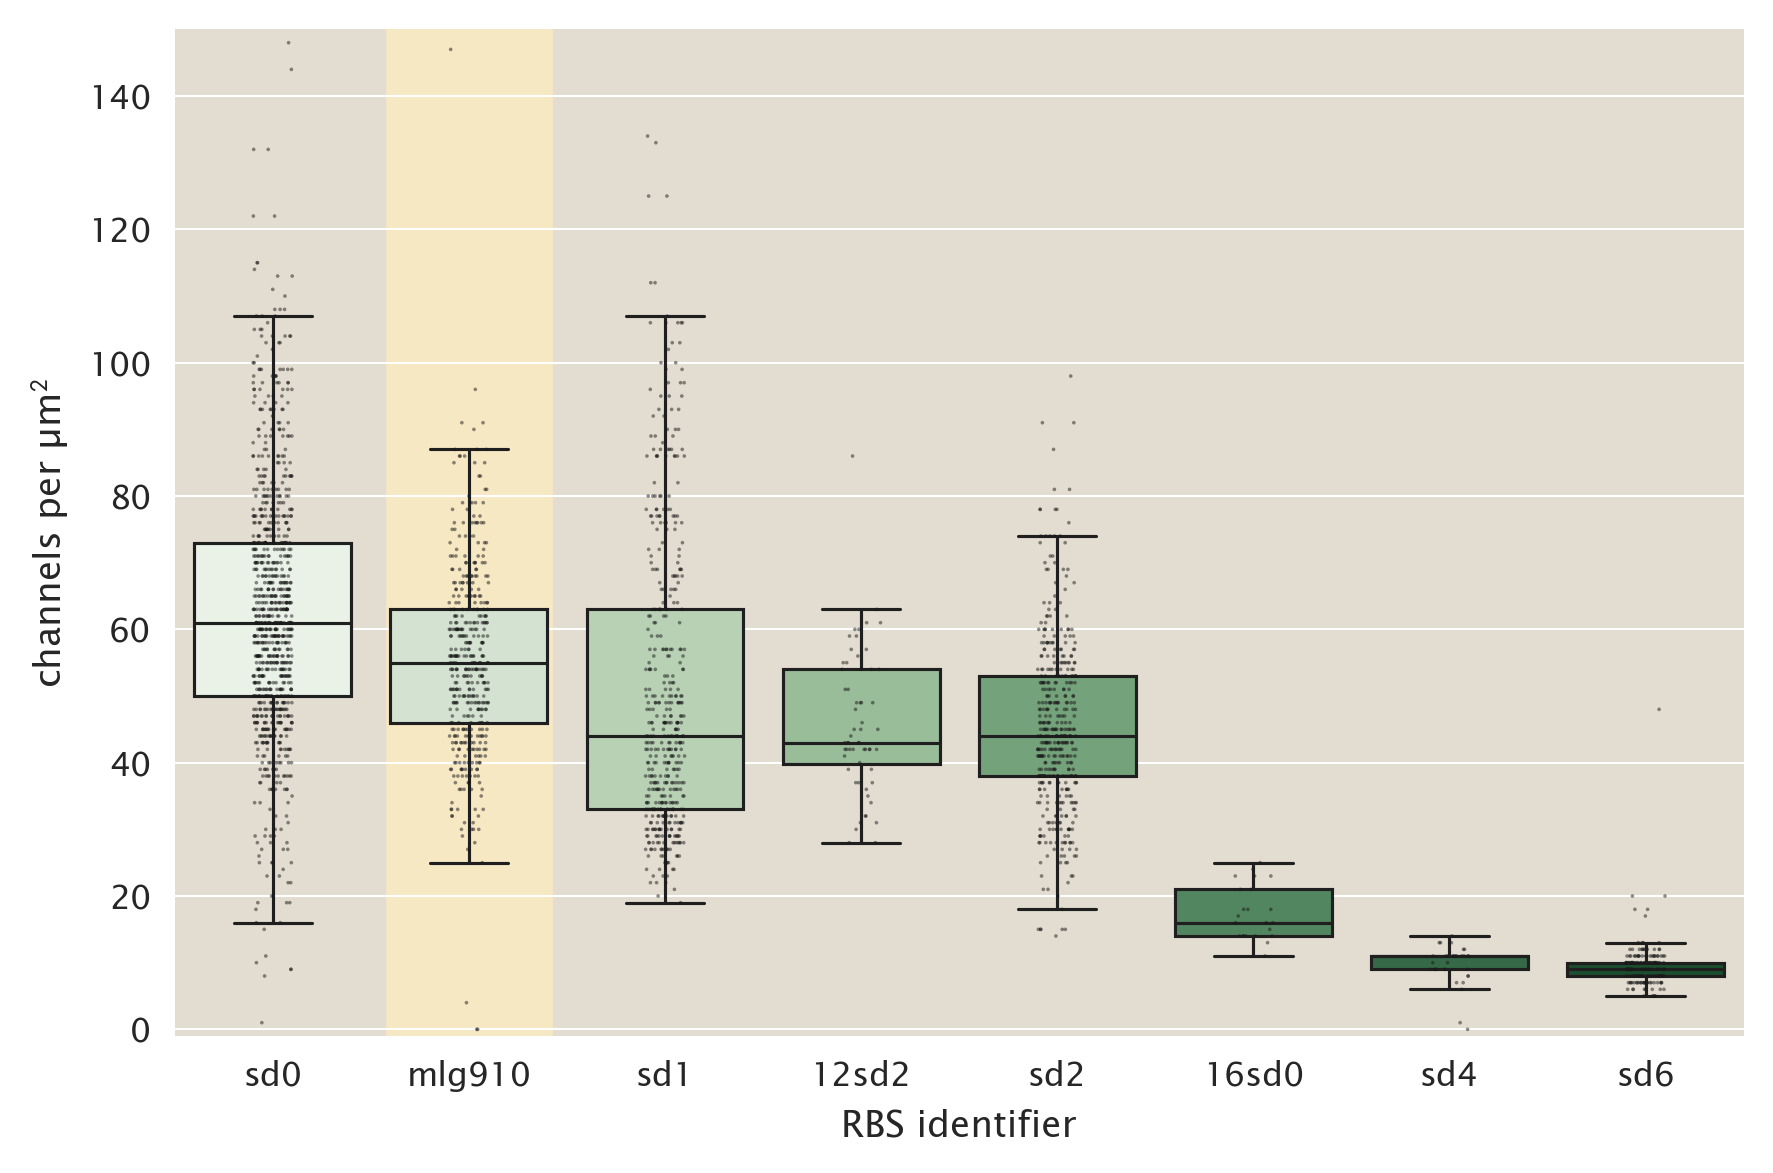

In [547]:
# Compute the channel density and regenerate the plot above. 
data['channel_density'] = (data['rescaled_intensity'] / au_per_channel).astype(int)

# Rank order the strains by expression.
order = data.groupby('rbs')['channel_density'].mean().sort_values()[::-1].index

# Set up the figure axis.
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# Plot the box-whiskers and the jitter plot.
_ = sns.boxplot(x='rbs', y='channel_density', data=data, palette='Greens', order=order,
           linewidth=0.75, ax=ax, fliersize=0, saturation=0.5, )
_ = sns.stripplot(x='rbs', y='channel_density', data=data, order=order,
            jitter=True, alpha=0.5, marker='.', size=1.75, color='k') 

# Add an indicator to the standard candle.
# ax.set_ylim([-10000, 8E5])
ax.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], color='#FFEDC0', lw=40, alpha=0.75, zorder=0)

# Add labels, format, and save the plot
ax.set_ylim([-1, 150])
ax.set_xlabel('RBS identifier')
ax.set_ylabel('channels per µm$^2$')
plt.tight_layout()
plt.savefig('../figs/analysis/rbs_channel_density_boxplots.pdf', bbox_inches='tight')

## Analyzing the shock data 

In [548]:
# Look at the intensity distribution for survivors vs goners. 
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Rescale the intensity to the maximum exposure of the whole data set. 
max_exp = data['exposure_ms'].max()
rescaled_exposure = max_exp / shock_data['exposure_ms']
shock_data['rescaled_intensity'] = (shock_data['intensity'] - shock_data['mean_bg']) * rescaled_exposure

# Prune it by excluding negative values and removing 10sd1.
shock_data = shock_data[(shock_data['rbs'] != '10sd1')  & (shock_data['rescaled_intensity'] > 0)]

# Include now channel density and error. 
shock_data['channel_density'] = (shock_data['rescaled_intensity'] / au_per_channel).astype(int)
shock_data['density_err'] = (shock_data['channel_density'] * PERC_ERR).astype(int)

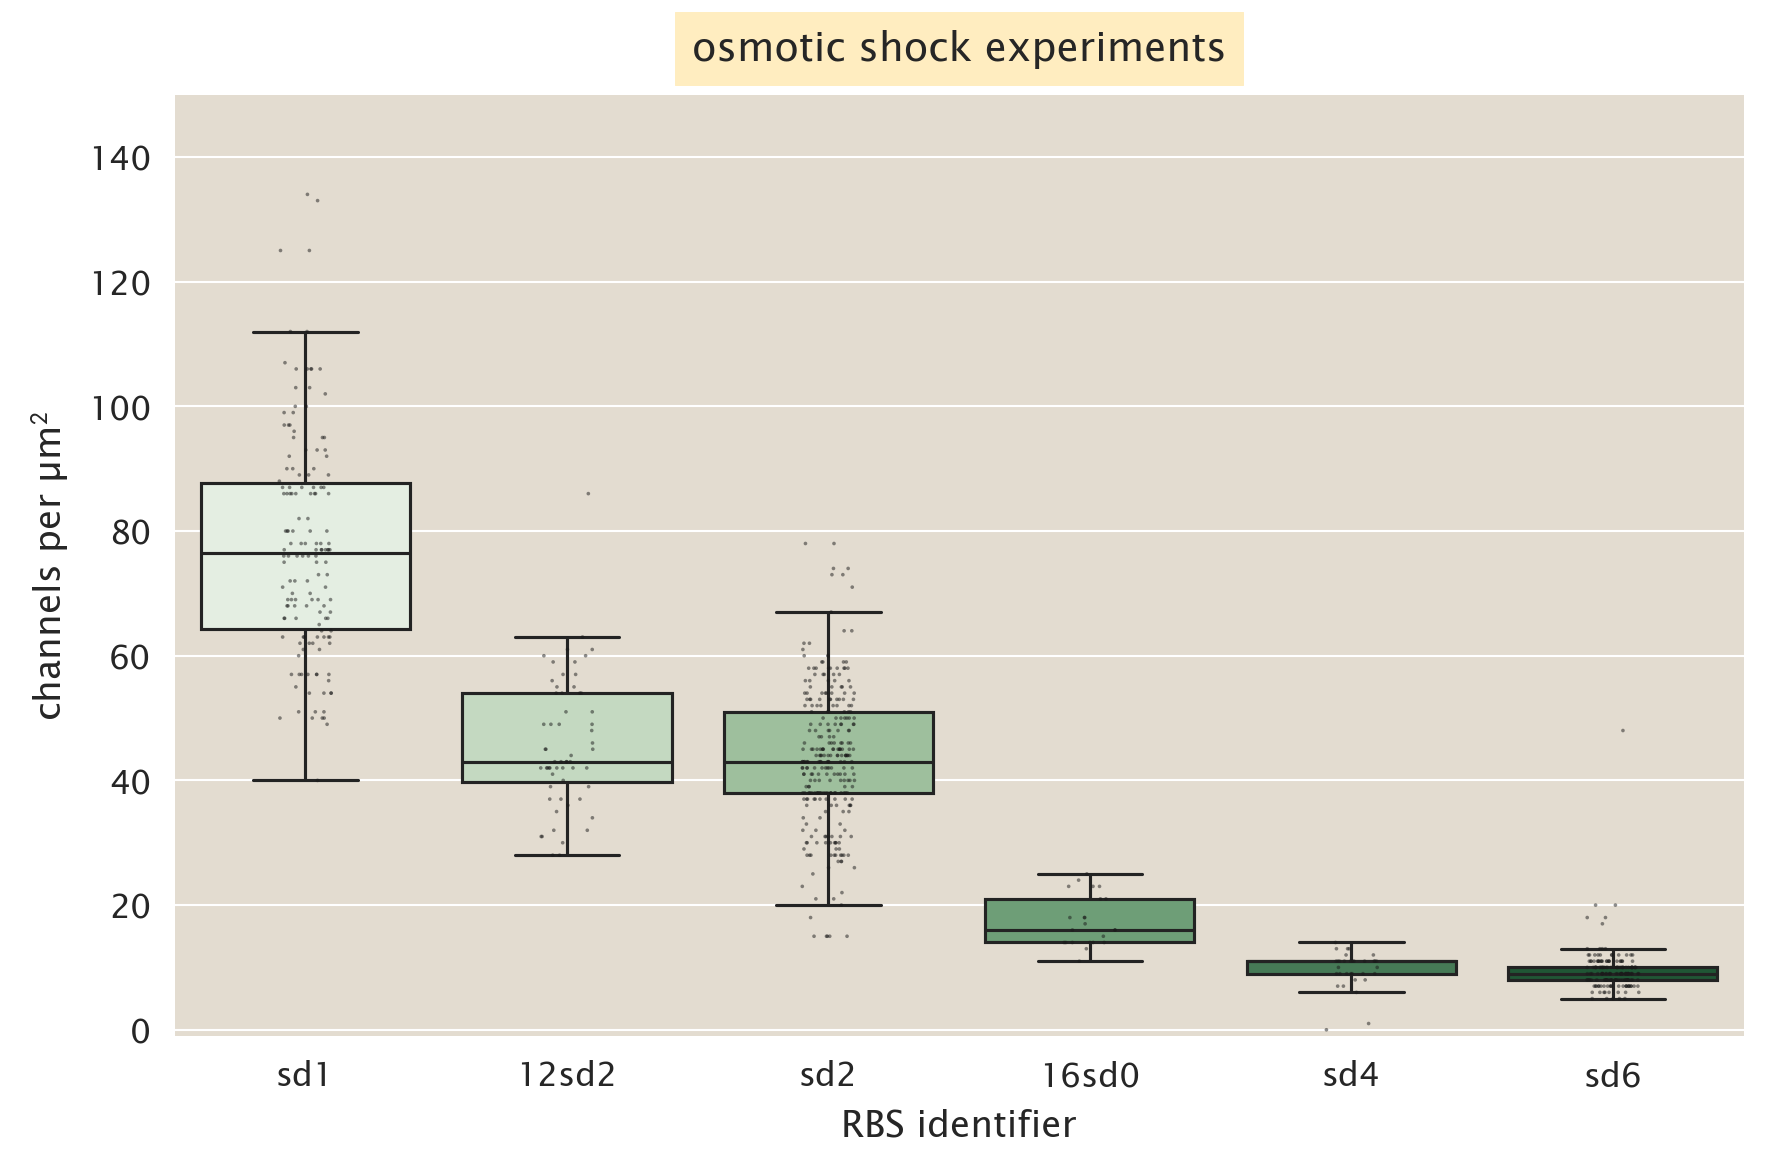

In [549]:
# Now show only those cells which underwent shock. 
order = shock_data.groupby('rbs')['channel_density'].mean().sort_values()[::-1].index

# Set up the figure axis.
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# Plot the box-whiskers and the jitter plot.
_ = sns.boxplot(x='rbs', y='channel_density', data=shock_data, palette='Greens', order=order,
           linewidth=0.75, ax=ax, fliersize=0, saturation=0.5, )
_ = sns.stripplot(x='rbs', y='channel_density', data=shock_data, order=order,
            jitter=True, alpha=0.5, marker='.', size=1.75, color='k') 


# Add labels, format, and save the plot
ax.set_ylim([-1, 150])
ax.set_xlabel('RBS identifier')
ax.set_ylabel('channels per µm$^2$')
ax.set_title('osmotic shock experiments', backgroundcolor='#FFEDC0', y=1.01)
plt.tight_layout()
plt.savefig('../figs/analysis/shock_data_channel_density_boxplots.pdf', bbox_inches='tight')


### 1. Bin by strain

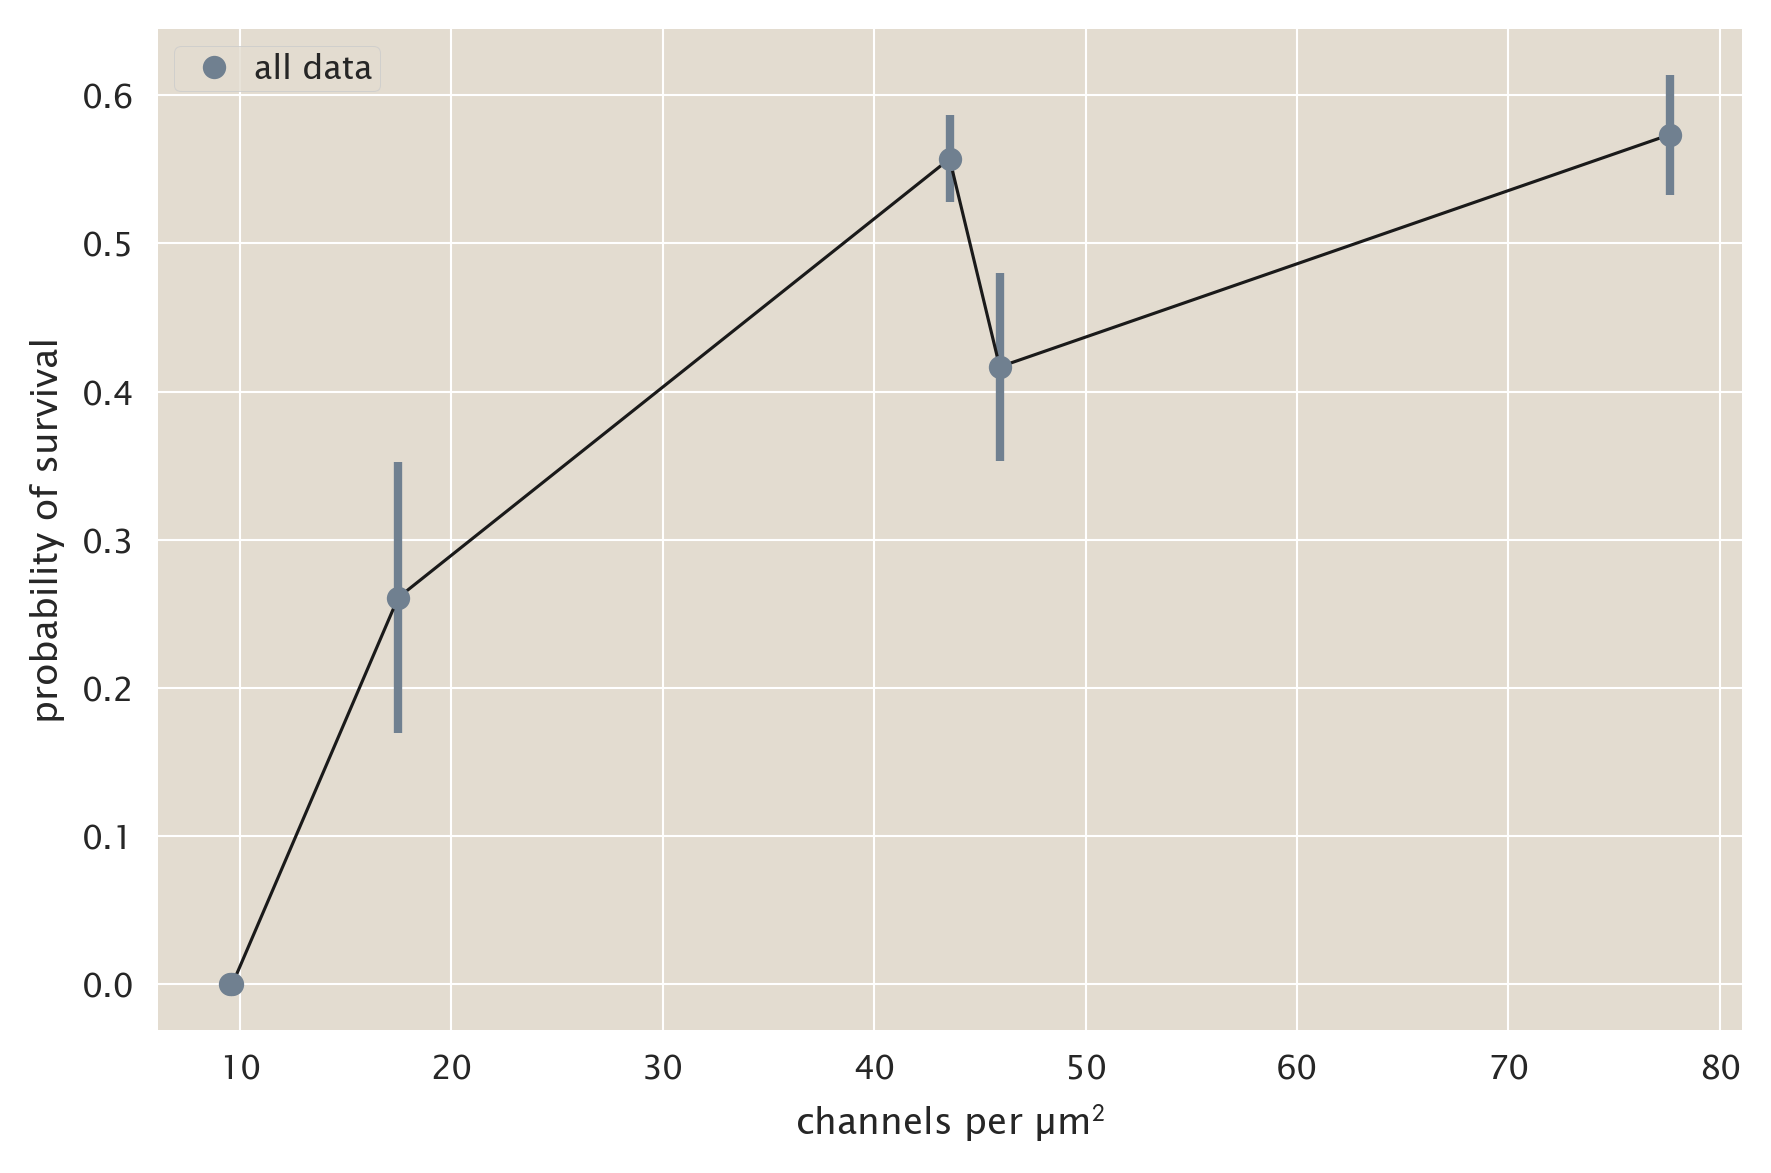

In [550]:
# Group the data by strain and compute the statistics. 
strain_grouped = mscl.compute_survival_stats(shock_data, groupby='rbs')
strain_grouped.sort_values(by='mean_chan', inplace=True)

# plot the survival curve.
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('probability of survival')
_ = ax.plot(strain_grouped['mean_chan'], strain_grouped['prob'], 'k-', lw=0.75, label='__nolegend__')
_ = ax.plot(strain_grouped['mean_chan'], strain_grouped['prob'], 'o', color='slategray',
           label='all data')
_ = ax.errorbar(strain_grouped['mean_chan'], strain_grouped['prob'], strain_grouped['err'],
               linestyle='none', color='slategray', label='__nolegend__')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../figs/analysis/all_data_survival_strain_bin.pdf', bbox_inches='tight')

/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


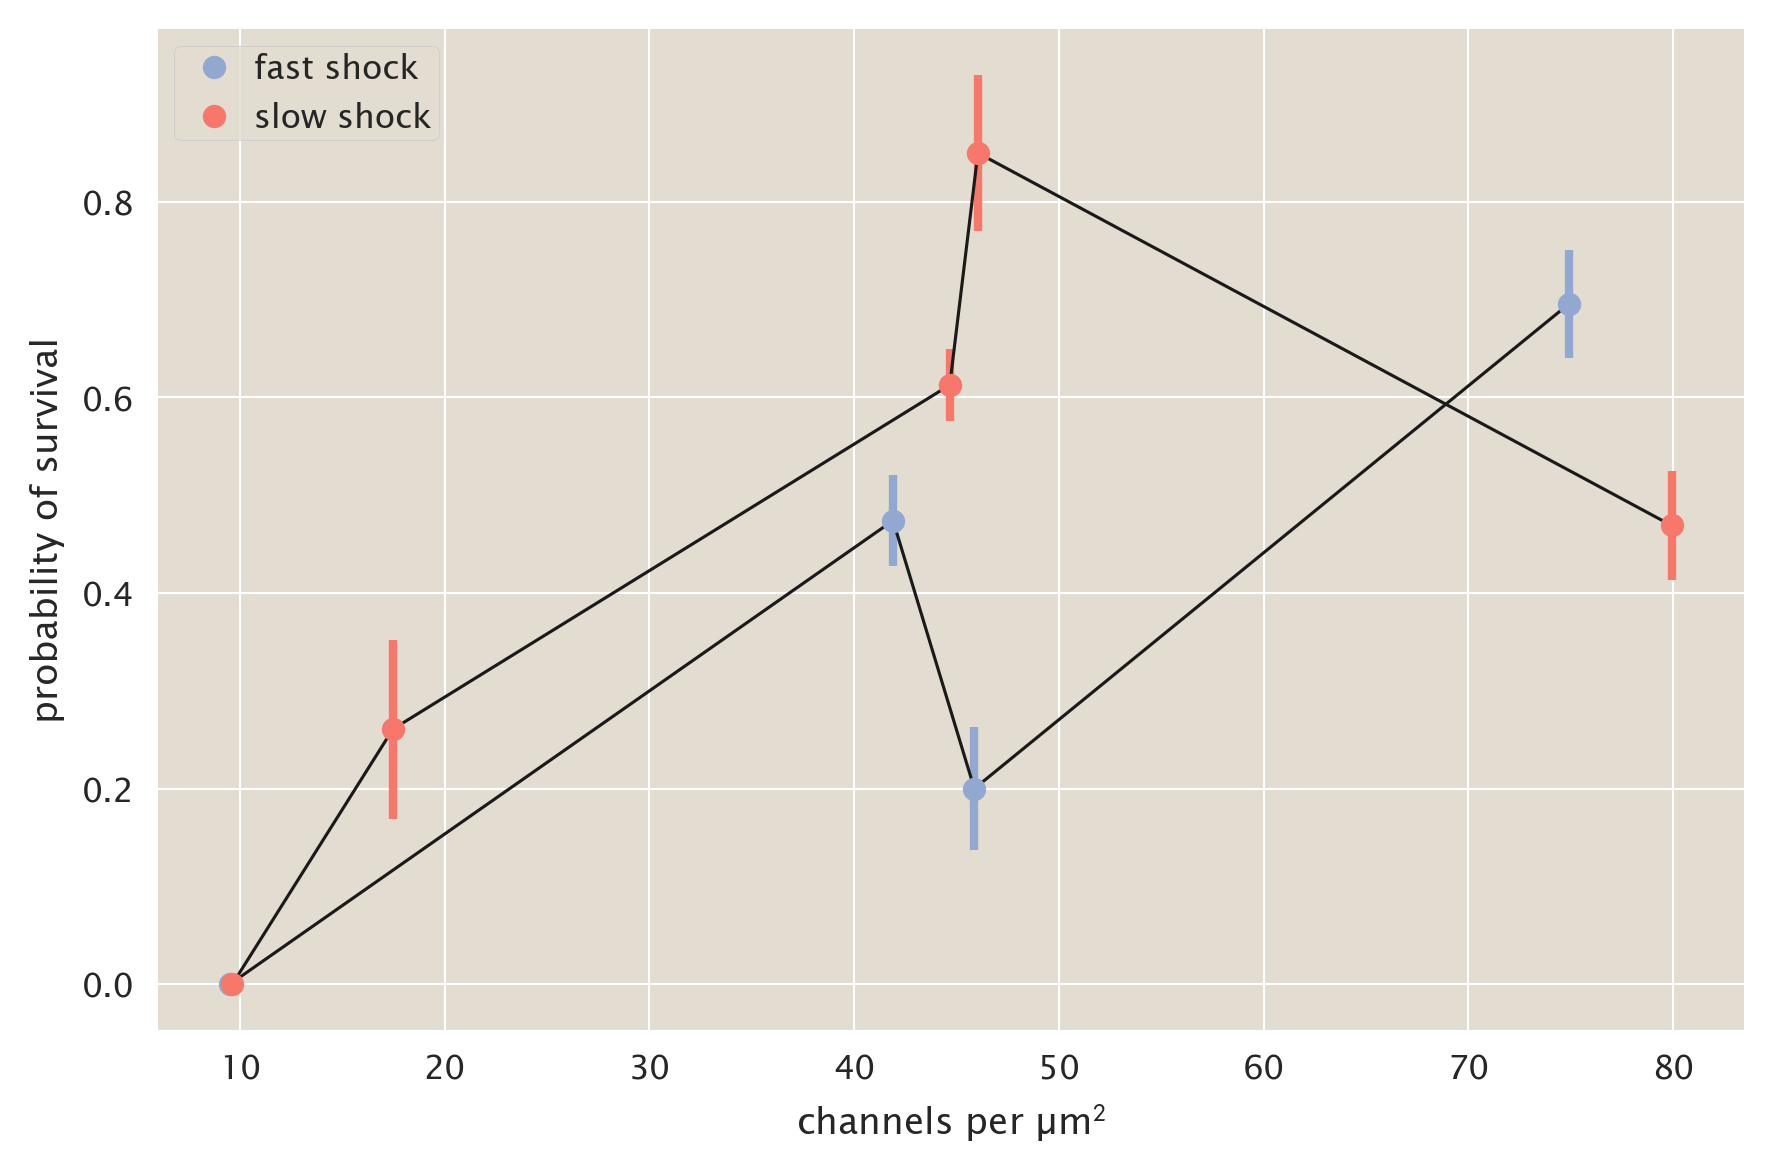

In [551]:
# now group by shock group and plot the survival curves. 
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'
stats = mscl.compute_survival_stats(shock_data, groupby=['rbs', 'shock_group'])

# Plot the survival curves.
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('probability of survival')
colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
grouped = stats.groupby(['shock_group'])
for g, d in grouped:
    d.sort_values(by='mean_chan', inplace=True)
    ax.plot(d['mean_chan'], d['prob'], 'k-', lw=0.75, label='__nolegend__')
    ax.plot(d['mean_chan'], d['prob'], 'o', color=colors[g], label='{0} shock'.format(g)) 
    ax.errorbar(d['mean_chan'], d['prob'], d['err'], color=colors[g], linestyle='none',
               label='__nolegend__')
    
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('../figs/analysis/shock_group_survival_curve_strain_bin.pdf', bbox_inches='tight')


###  2. Binning by density window

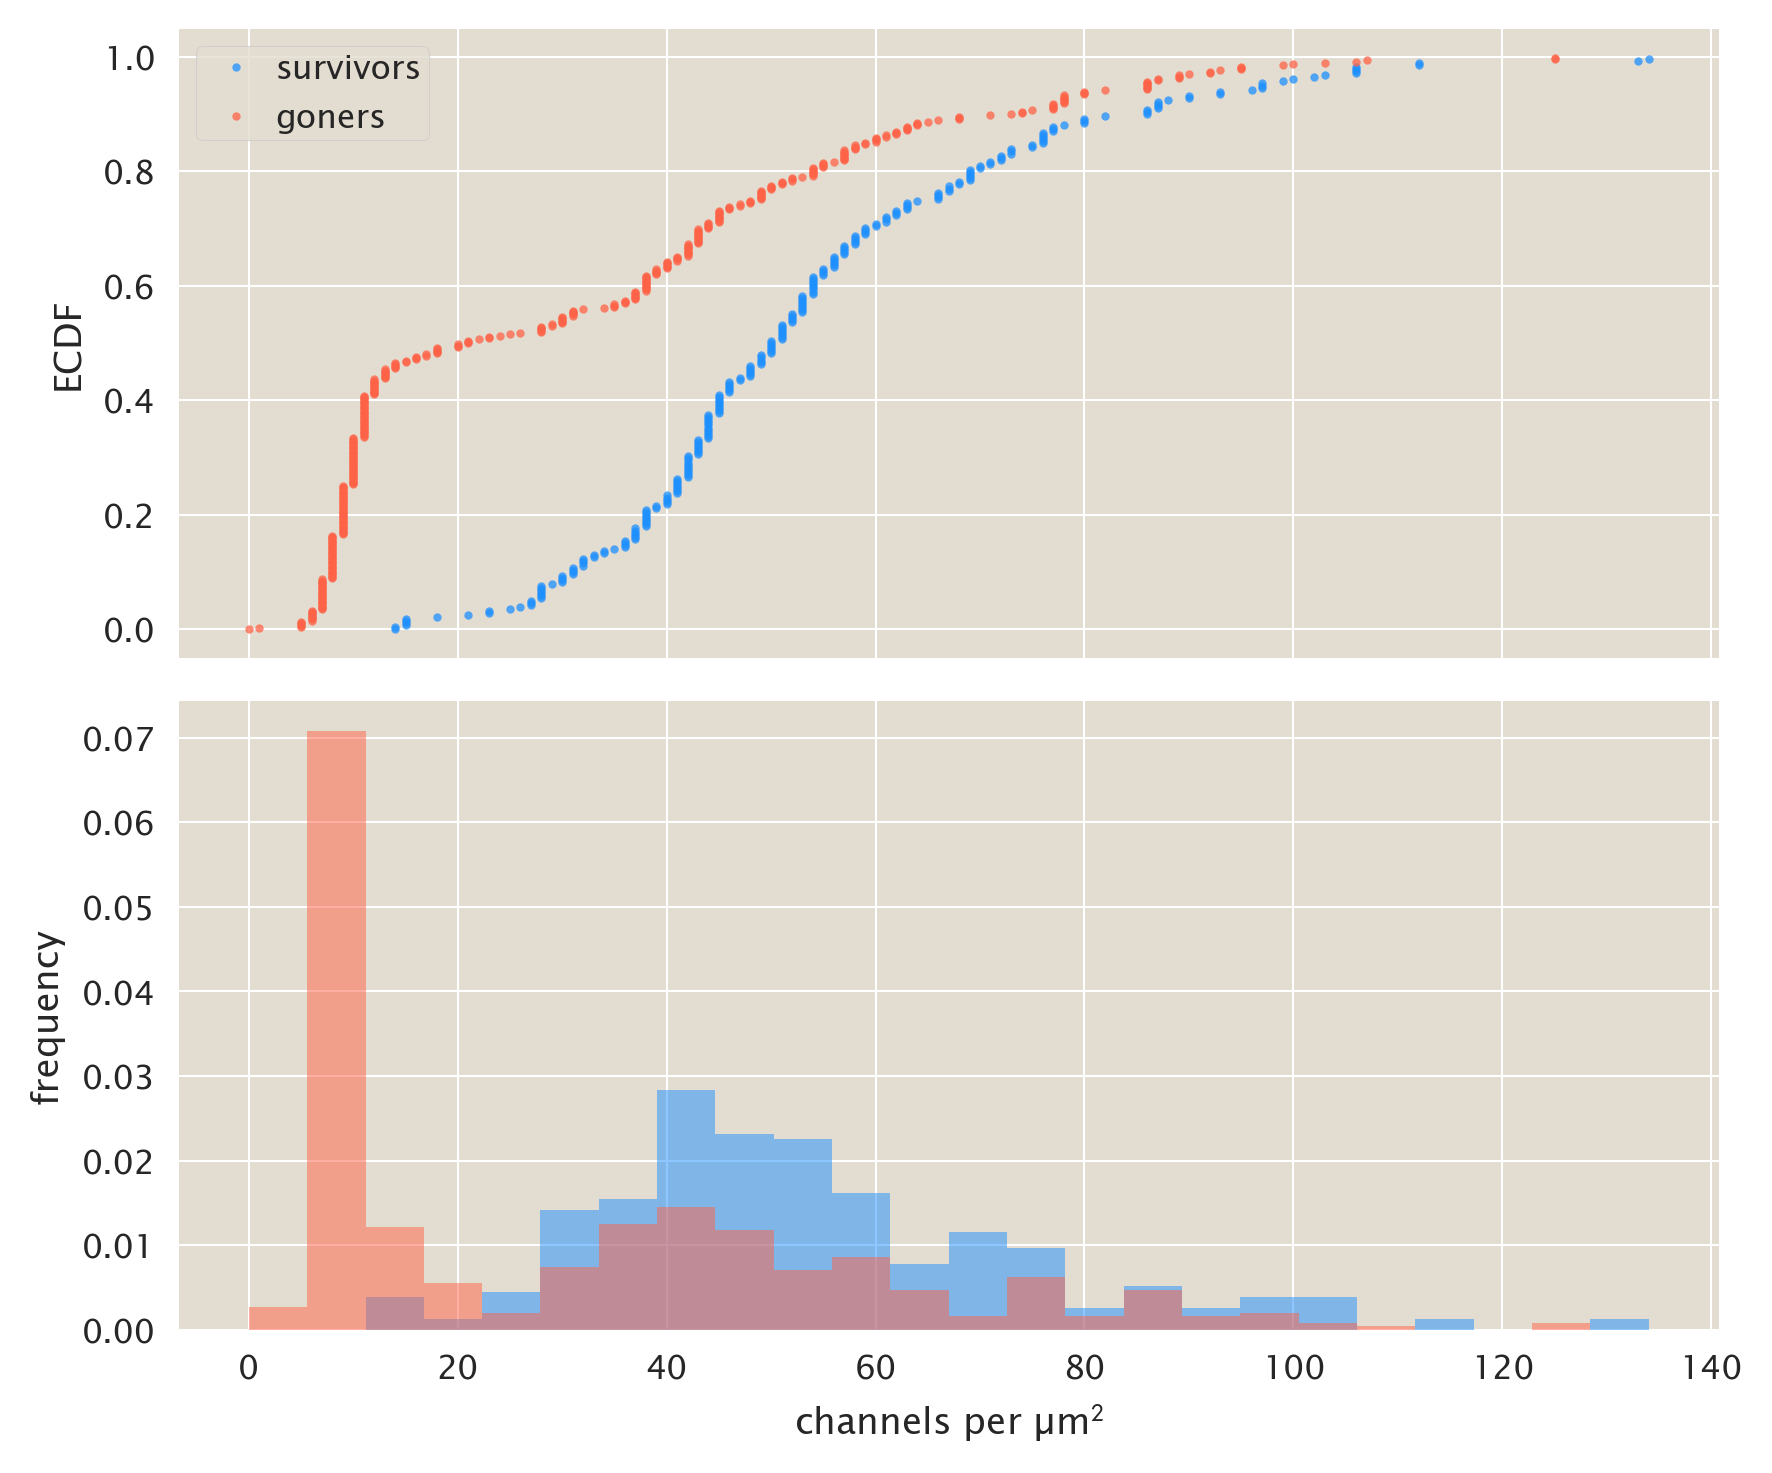

In [552]:
# Compute the ECDF
surv_x, surv_y = mscl.ecdf(shock_data[shock_data['survival']==True]['channel_density'])
death_x, death_y = mscl.ecdf(shock_data[shock_data['survival']==False]['channel_density'])

# Compute the histograms.
bins = np.linspace(shock_data['channel_density'].min(), shock_data['channel_density'].max(), 25)

fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('frequency')
_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5, normed=True)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5, normed=True)
_legend = ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../figs/analysis/survival_density_distribution.pdf', bbox_inches='tight',
           dpi=200)


In [553]:
# Include some information about the shock group.
shock_data.loc[:, 'shock_group'] = 'all'

# Bin the data in units of 10 channels per square micron.
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin)

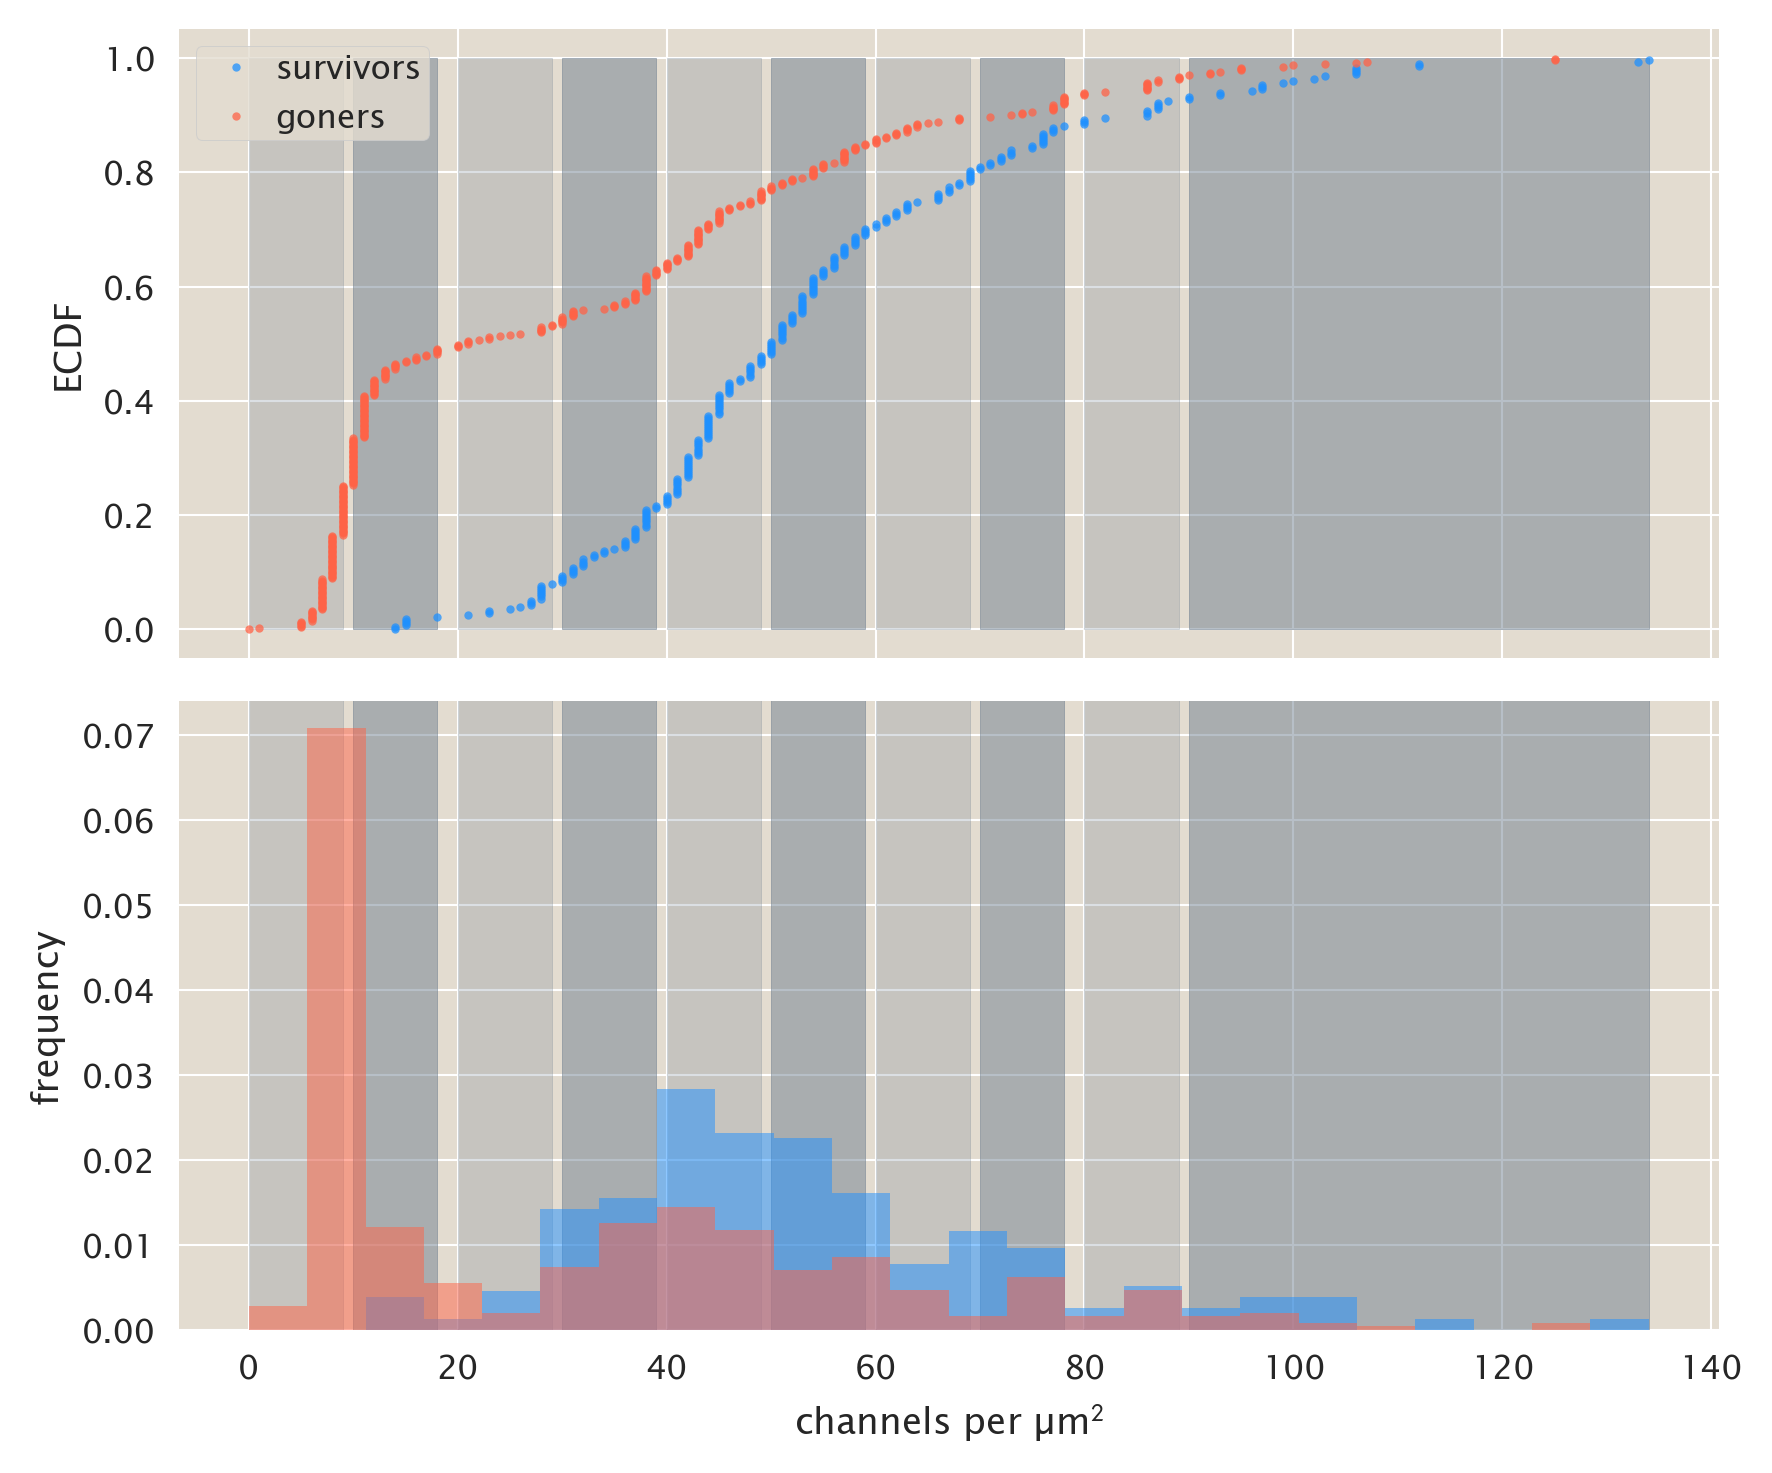

In [554]:
# Show the distribution plot as above, but with the bin numbers indicated. 
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('frequency')
bins = np.linspace(shock_data['channel_density'].min(), shock_data['channel_density'].max(), 25)

_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5, normed=True)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5, normed=True)

# Shade the bins. 
binned_data.sort_values(by='channel_density', inplace=True)
grouped = binned_data.groupby('bin_number')
bins = np.arange(0, shock_data['channel_density'].max() + channel_bin, channel_bin)
for g, d in grouped:
    if g%2 == 0: 
         alpha=0.25
    else:
        alpha = 0.5 
    for i, a in enumerate(ax):
        if i == 0:
            top = 1
        else: 
             top = 150
        y = np.linspace(0, top, 500)
        a.fill_betweenx(y, d['channel_density'].min(), d['channel_density'].max(), color='slategray', alpha=alpha)
_legend = ax[0].legend(loc='upper left')

ax[1].set_ylim([0, 0.074])
plt.tight_layout()
plt.savefig('../figs/analysis/survival_density_distribution_with_bins.pdf', bbox_inches='tight',
           dpi=200)



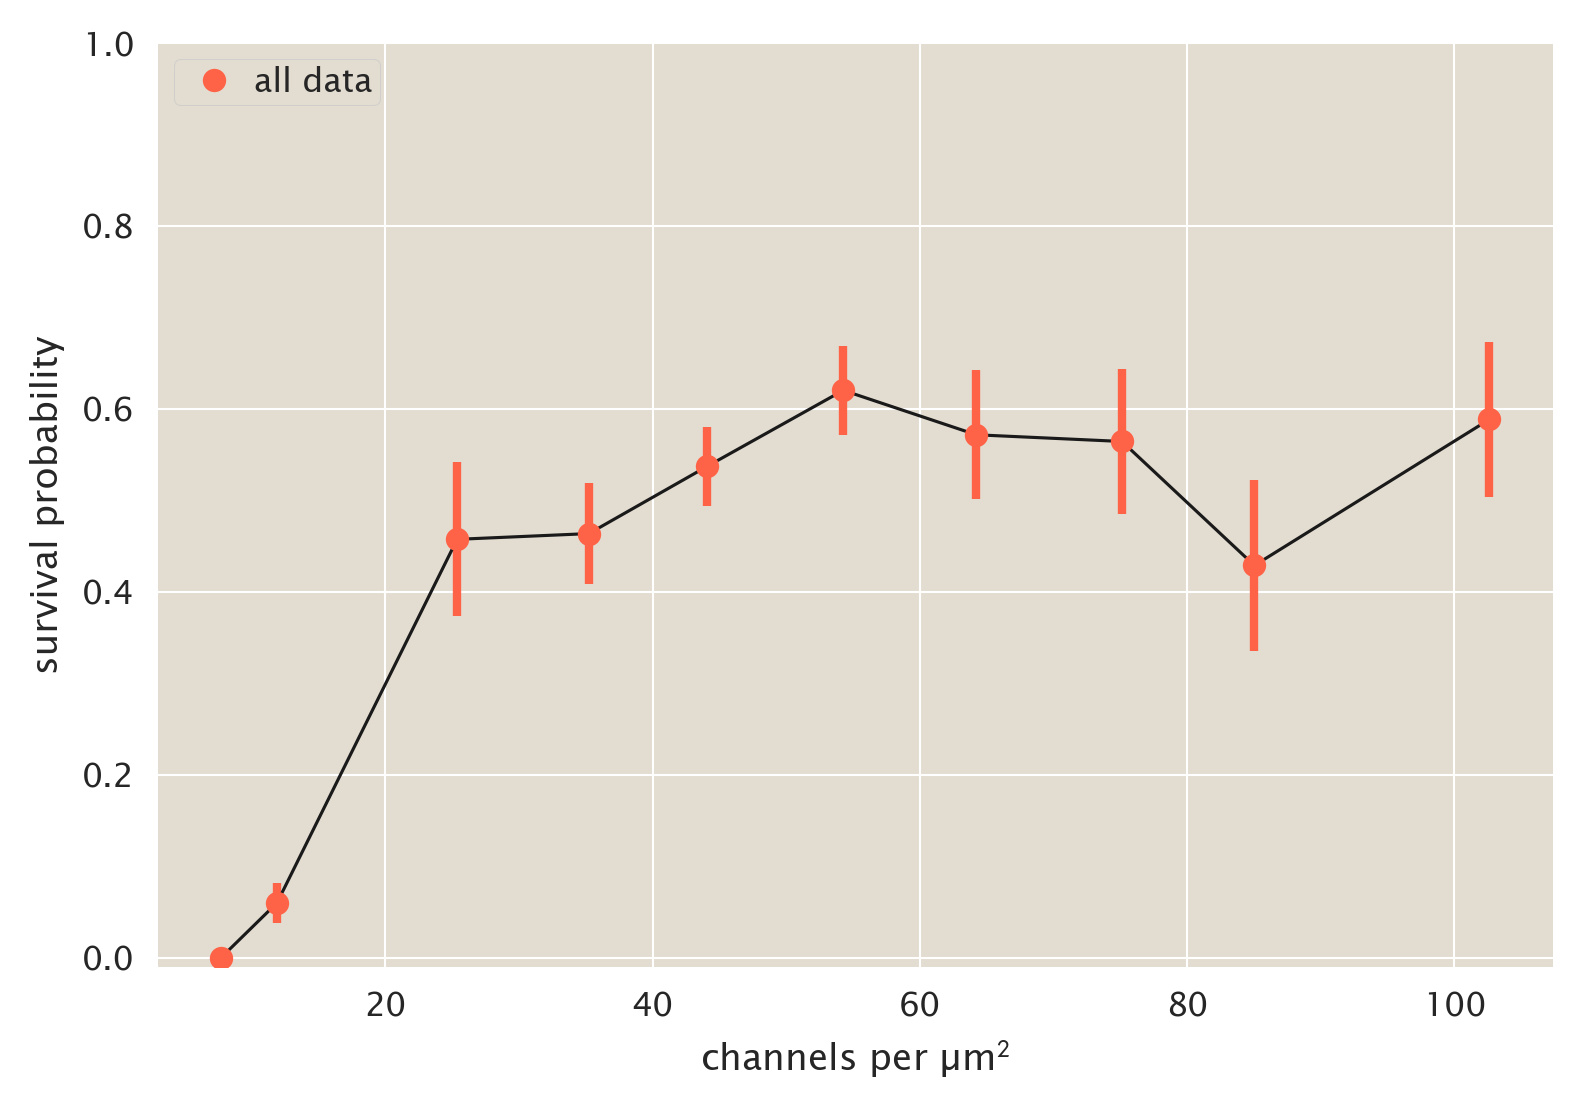

In [555]:
stats = binned_data.groupby('bin_number').apply(mscl.compute_survival_stats)
stats.sort_values(by='mean_chan', inplace=True)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')
_ = ax.plot(stats['mean_chan'], stats['prob'], lw=0.75, color='k', label='__nolegend__')
_ = ax.errorbar(stats['mean_chan'], stats['prob'], stats['err'], color='tomato',
           linestyle='none', label='__nolegend__')
_ = ax.plot(stats['mean_chan'], stats['prob'], 'o', markerfacecolor='tomato', 
           label='all data')

ax.set_ylim([-0.01, 1])

plt.legend(loc='upper left')
plt.savefig('../figs/analysis/all_data_nbins_10.pdf', bbox_inches='tight')     

In [556]:
# Bin the data by the shock group and show slow and fast. 
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin,
                                  min_cells=10)
stats = mscl.compute_survival_stats(binned_data)


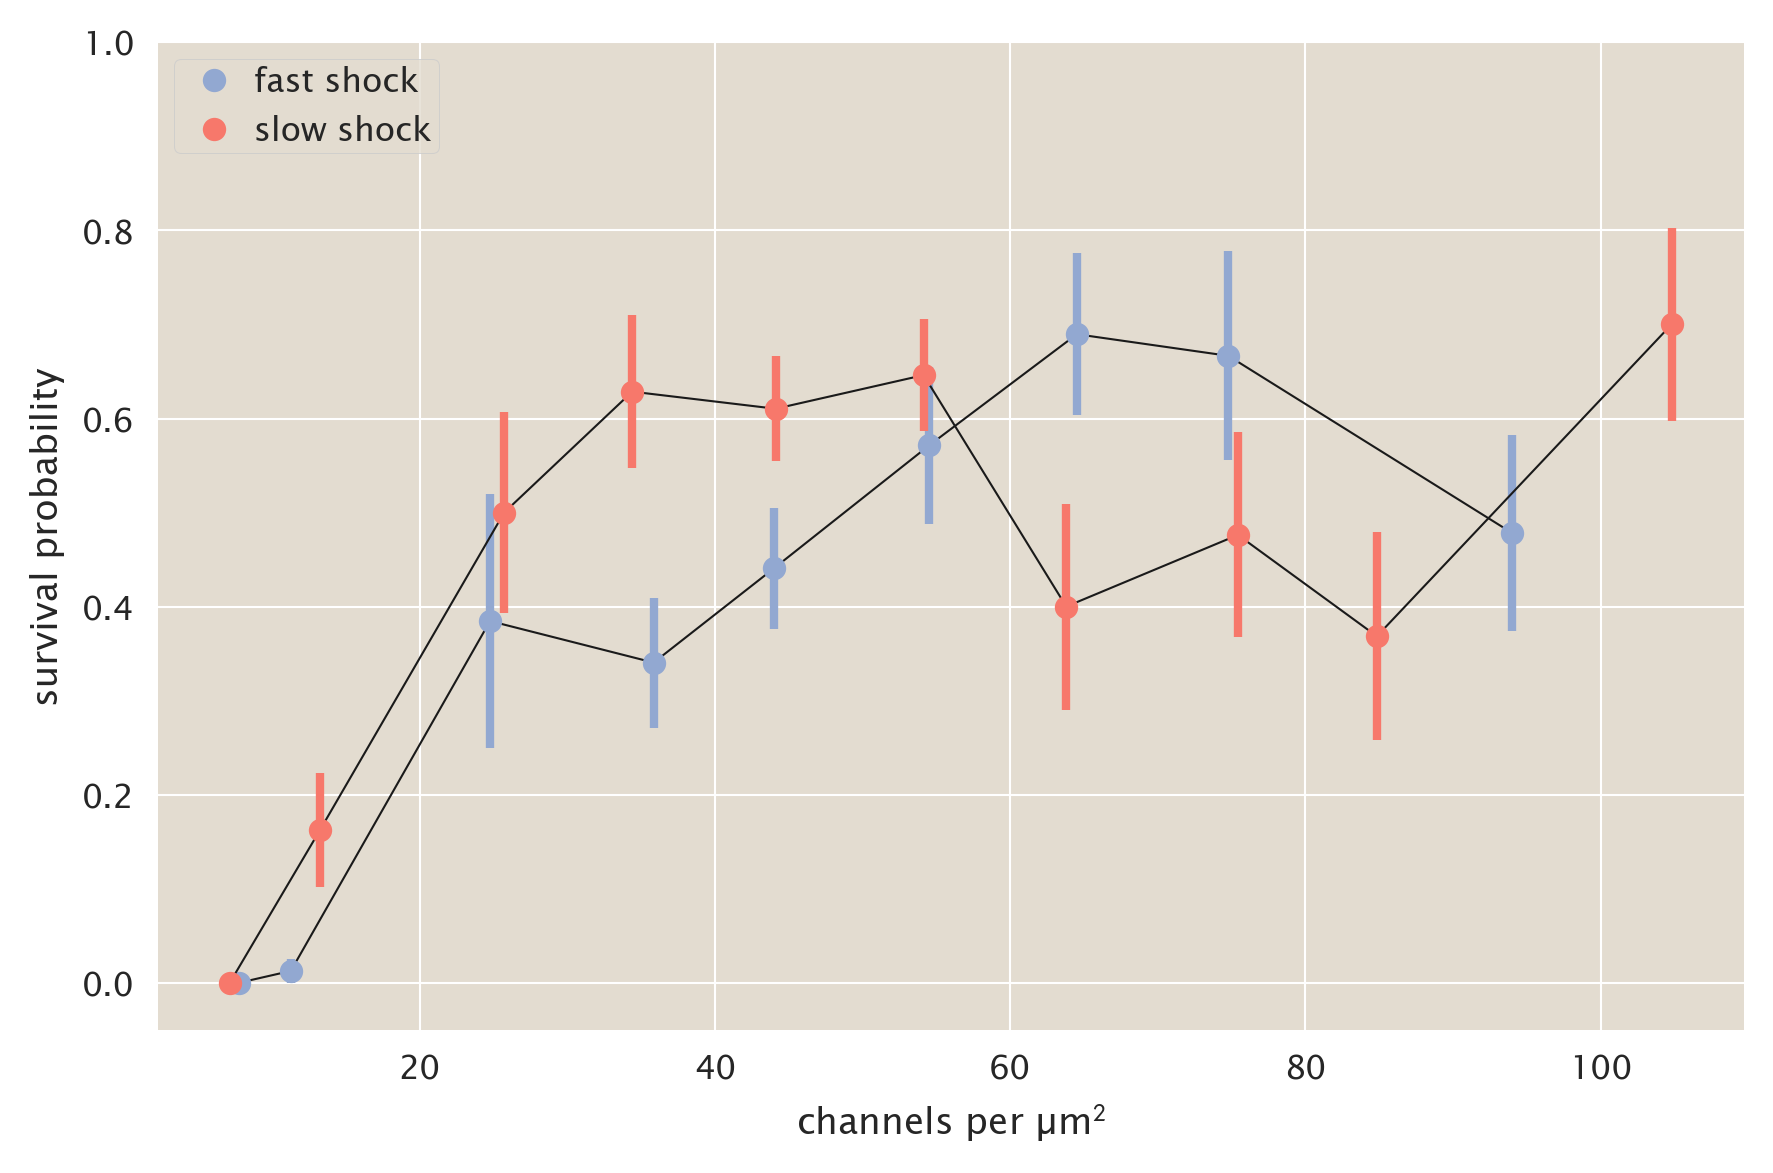

In [557]:
# Generate the figure of the shock rates. 
grouped = stats.groupby('shock_group')
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')

colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
for g, d in grouped:
    _ = ax.errorbar(d['mean_chan'], d['prob'],  d['err'], color=colors[g],
                    label='__nolegend__', linestyle='none')
    _ = ax.plot(d['mean_chan'], d['prob'], 'k-', lw=0.5, label='__nolegend__')
    _ = ax.plot(d['mean_chan'], d['prob'],  'o', color=colors[g], label='{0} shock'.format(g))

_ = ax.legend(loc='upper left')
ax.set_ylim([-0.05, 1])
plt.tight_layout()
plt.savefig('../figs/analysis/shock_group_bin10_survival_curve.pdf', bbox_inches='tight')

### 3. Logistic Regression 

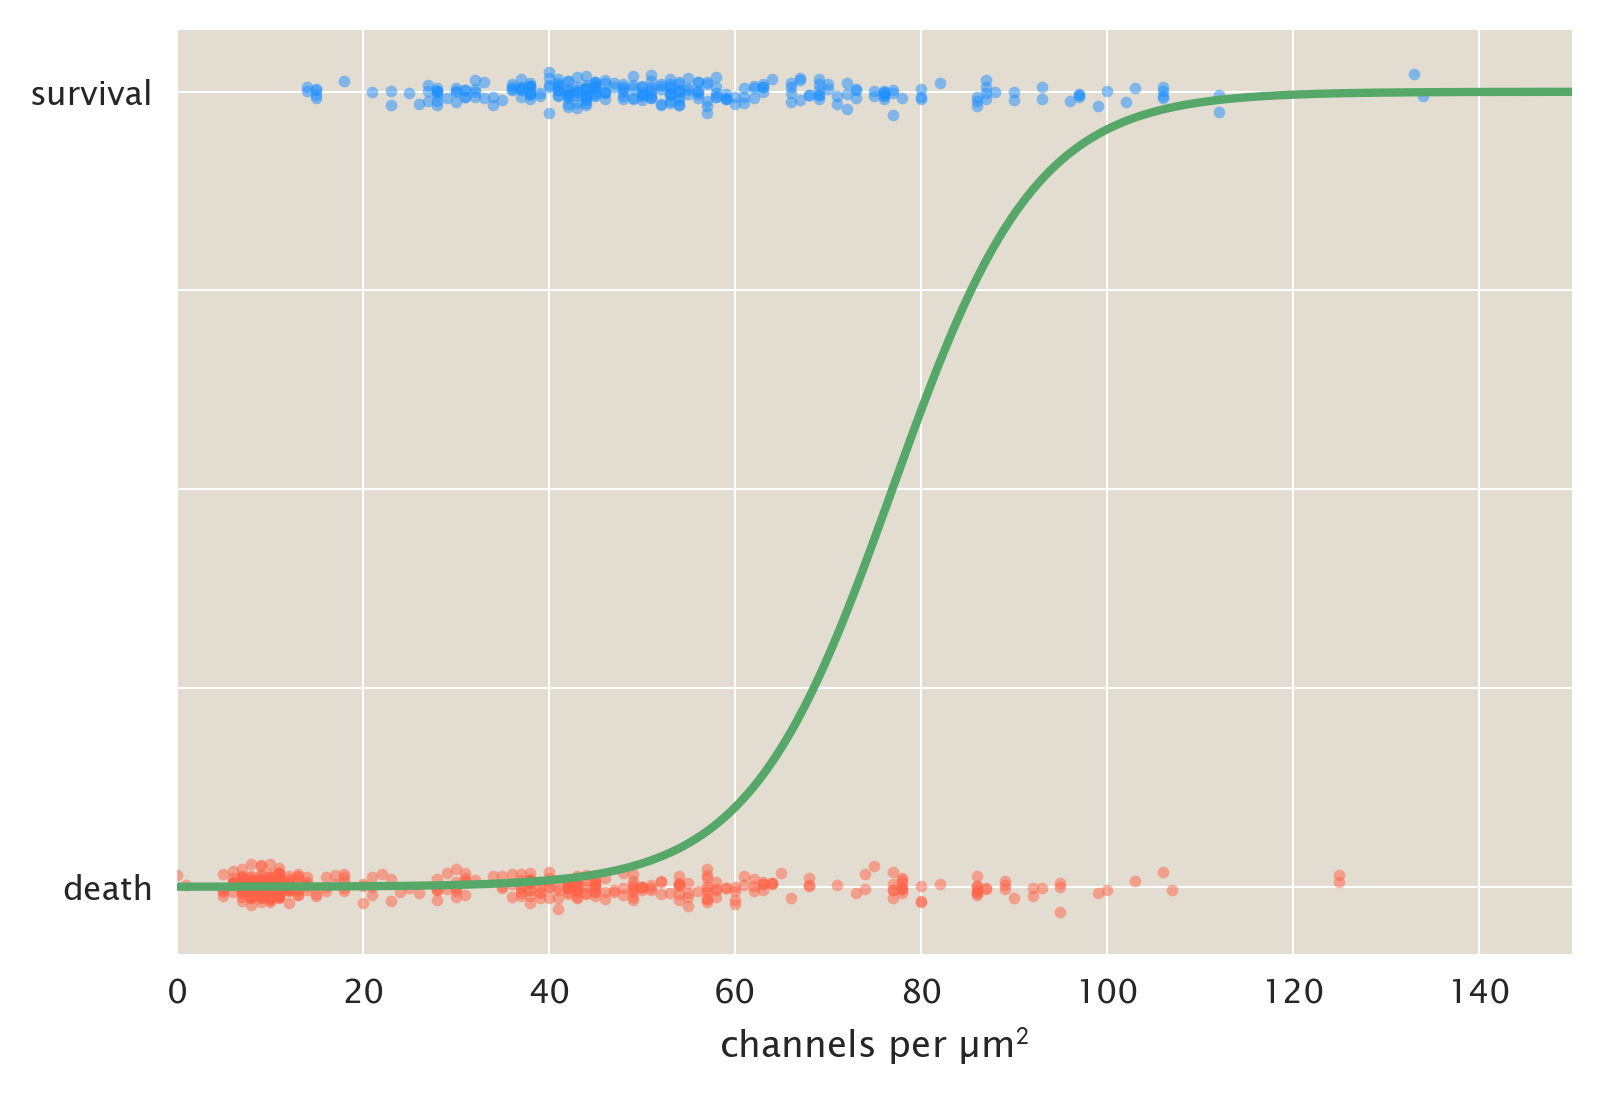

In [560]:
# Plot the rugplot of survival and death for everything.
grouped = shock_data.groupby('survival')
markers = {True: 'v', False: '^'}
colors = {True: 'dodgerblue', False:'tomato'}

# Set up the figure. 
fig, ax = plt.subplots(1,1, figsize=(6, 4))
for g, d in grouped:
    ax.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)), color=colors[g],
           marker='.', alpha=0.5, linestyle='None')
density = np.linspace(0, 150, 500)

# make a fake probability curve
theo = 1 / (1 + np.exp(-(-10 + 0.13*density)))
ax.plot(density, theo, color='g')
ax.set_yticks([0, .25, .5, .75, 1])
ax.set_yticklabels(['death', '', '', '', 'survival'])
ax.set_xlim([0, 150])
ax.set_xlabel('channels per µm$^2$')
# plt.savefig('../figs/analysis/rugplot.pdf', bbox_inches='tight')
plt.savefig('../figs/analysis/fake_logistic_regression.pdf', bbox_inches='tight')

As I've discussed before, the model for survival is binomial,

$$
P(p_s \, \vert\, \rho) \propto \text{Binomial}(n_i, N_i\, \vert \, p_s, \rho)P(p_s).
$$

However, I don't have the luxury of having many measurements of survival with a single, well-defined channel density. Rather, I would like to know the probability of survival $p_s$ 

which, ignoring the flow rate fly in the ointment (for now), can be written more explicitly as
$$
P(p_s \, \vert\, \rho) \propto \text{Bernoulli}(y_i, p_s(\rho))
$$

In [216]:
model = pm.Model()
with model:
    beta_0 = pm.Normal('b_0', mu=0, sd=20, testval=-2)
    beta_1 = pm.Normal('b_1', mu=0, sd=20, testval=0)
    
    rho = shock_data['channel_density'].values
    mu = beta_0 + beta_1 * rho
    like = pm.Bernoulli('like', p=mscl.theano_logistic(mu), observed=shock_data['survival'].values.astype(int))
    
    # Sample the distribution.
    start = pm.find_MAP(model=model)
    step = pm.Metropolis()
    burn = pm.sample(draws=10000, start=start, step=step, njobs=None)
    step = pm.Metropolis()
    trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
    df = mscl.trace_to_df(trace,  model=model) 
    stats = mscl.compute_mcmc_statistics(df)

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 432.536158
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 13


100%|██████████| 50000/50000 [00:28<00:00, 1746.19it/s]


In [217]:
# Compute the credible region.
var = np.linspace(-1, 150, 500)
cred_region = np.zeros((2, len(var)))
for i, v in enumerate(var):
    mu = df['b_0'].values + df['b_1'].values * v
    prob = (1 + np.exp(-mu))**-1
    cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95)
all_data_cred = np.copy(cred_region)

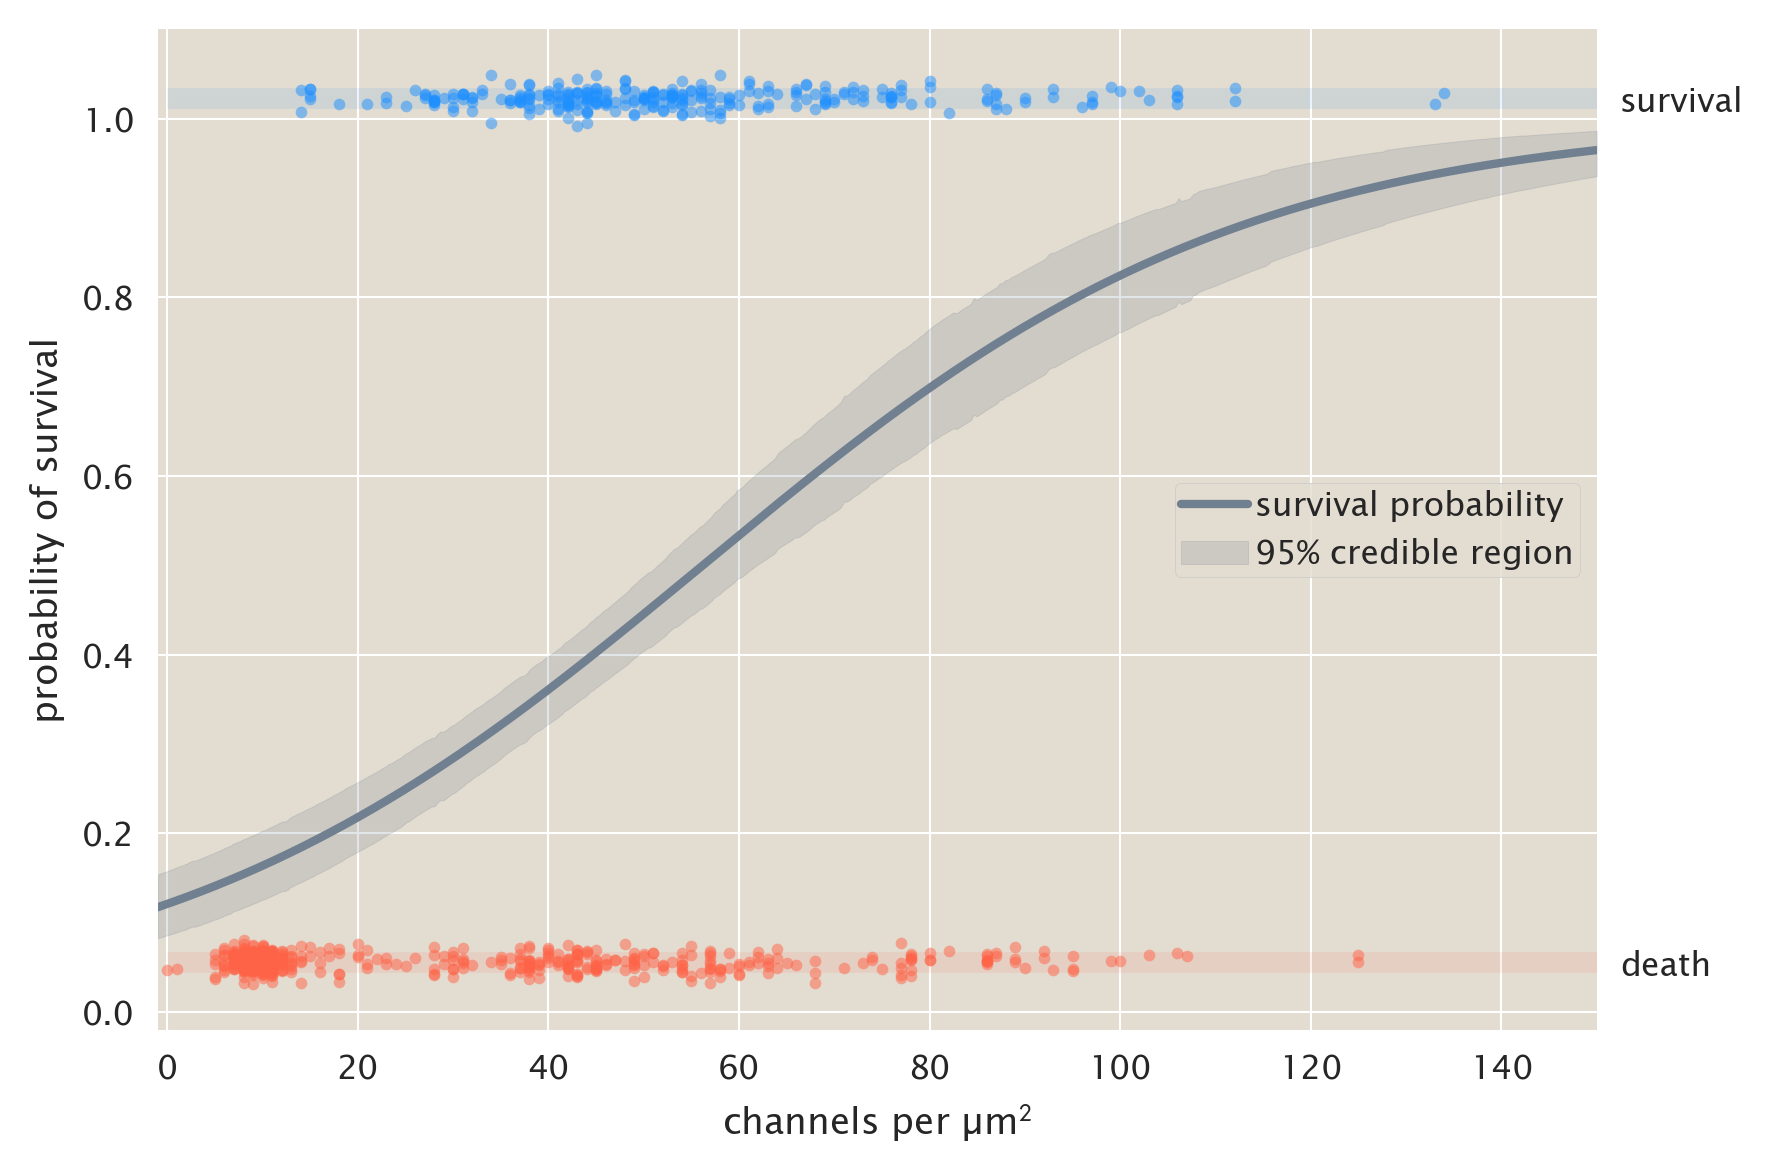

In [218]:
theo_mu = stats['b_0'][0] + stats['b_1'][0] *  var
prob = (1 + np.exp(-theo_mu))**-1
all_prob = np.copy(prob)
grouped = shock_data.groupby('survival')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax2 = ax.twinx()
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('probability of survival')
ax2.set_yticks([0, 1])
ax2.hlines(0, 0, 150, color='tomato', alpha=0.1, lw=5)
ax2.hlines(1, 0, 150, color='dodgerblue', alpha=0.1, lw=5)
ax2.set_yticklabels(['death', 'survival'])
ax.set_xlim([-1, 150])
ax.set_ylim([-0.02, 1.1])
ax2.grid(False)

# Plot the prediction curve and the credible region.
_ = ax.plot(var, prob, color='slategray', label='survival probability')
_ = ax.fill_between(var, cred_region[0, :], cred_region[1, :], color='slategray',
               alpha=0.2, label='95% credible region')

# Plot the rug of survival.
for g, d in grouped:
    ax2.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)), color=colors[g],
           marker='.', alpha=0.5, linestyle='None') 
ax.legend(loc='center right')
plt.tight_layout()
plt.savefig('../figs/analysis/logistic_regression_all_data.pdf', bbox_inches='tight')

In [159]:
rho = np.linspace(0, 200, 500)
cred_region = np.zeros((2, len(rho)))
for i, val in enumerate(rho):
    mu =  df['b_0'].values + df['b_1'].values * rho[i]
    prob = (1 + np.exp(-mu))**-1
    cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95) 

In [160]:
#TODO: Fix this horrible function.
def multinomial_linear(coeff, variables):
    """
    Computes a multinomial linear relation of the form. 
    
          y = β_0 + β_1*x1 + β_2 * x2 ... + β_n * xn
    
    Parameters
    ----------
    coeff: list
        Array of coefficients for the linear model. The first entry
        is the intercept.
    variables: list of 1d-arrays
        List of x-variable corresponding to coefficients. This
         must be length 1 longer than coeff.
         
    Returns
    -------
    y: nd-array
        Result of the linear model. 
    """
    y = coeff[0] + coeff[1:] * variables[:]
    return y  

def mcmc_logistic_regression(obs, variables):
    model = pm.Model()
    with model:
        # Define the priors on the coefficients.
        beta_0 = pm.Normal('b_0', mu=0, sd=20) 
        beta_1 = pm.Normal('b_1', mu=0, sd=20) 
        
        # Compute the logit and probability.
        logit = beta_0 + beta_1 * variables
        prob = mscl.theano_logistic(logit)
       
        # Compute the likelihood.
        like = pm.Bernoulli('like', p=mscl.theano_logistic(logit), observed=obs)

        # Sample the distribution.
        start = pm.find_MAP()
        
        # Sample using metropolis
        step = pm.Metropolis()
        burn = pm.sample(draws=10000, start=start, step=step, njobs=None, progressbar=False)
        step = pm.Metropolis()
        trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
        
    # Convert results to a dataframe.
    df = mscl.trace_to_df(trace,  model=model) 
    stats = mscl.compute_mcmc_statistics(df)
    return [df, stats]


In [165]:
# Group by shock_rate
grouped = shock_data.groupby(['shock_group'])
var = np.linspace(0, 150, 500)

dfs, cred_regions, modes, group = [], [], [], []
for g, d in grouped:
    group.append(g)
    # Define the data
    obs = d['survival'].values.astype(int)
    variables = d['channel_density'].values
    
    # Sample the posterior
    df, stats = mcmc_logistic_regression(obs, variables)
    dfs.append(df)
    
    # Compute the statistics and credible regions
    modes.append([stats['b_0'][0], stats['b_1'][0]])    
    cred_region = np.zeros((2, len(var)))
    for i, v in enumerate(var):
        logit = df['b_0'] + v * df['b_1']
        prob = (1 + np.exp(-logit))**-1
        cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95) 
    cred_regions.append(cred_region) 

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 189.399818
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 50000/50000 [00:30<00:00, 1661.15it/s]


Optimization terminated successfully.
         Current function value: 230.752367
         Iterations: 7
         Function evaluations: 17
         Gradient evaluations: 11


100%|██████████| 50000/50000 [00:58<00:00, 850.91it/s] 


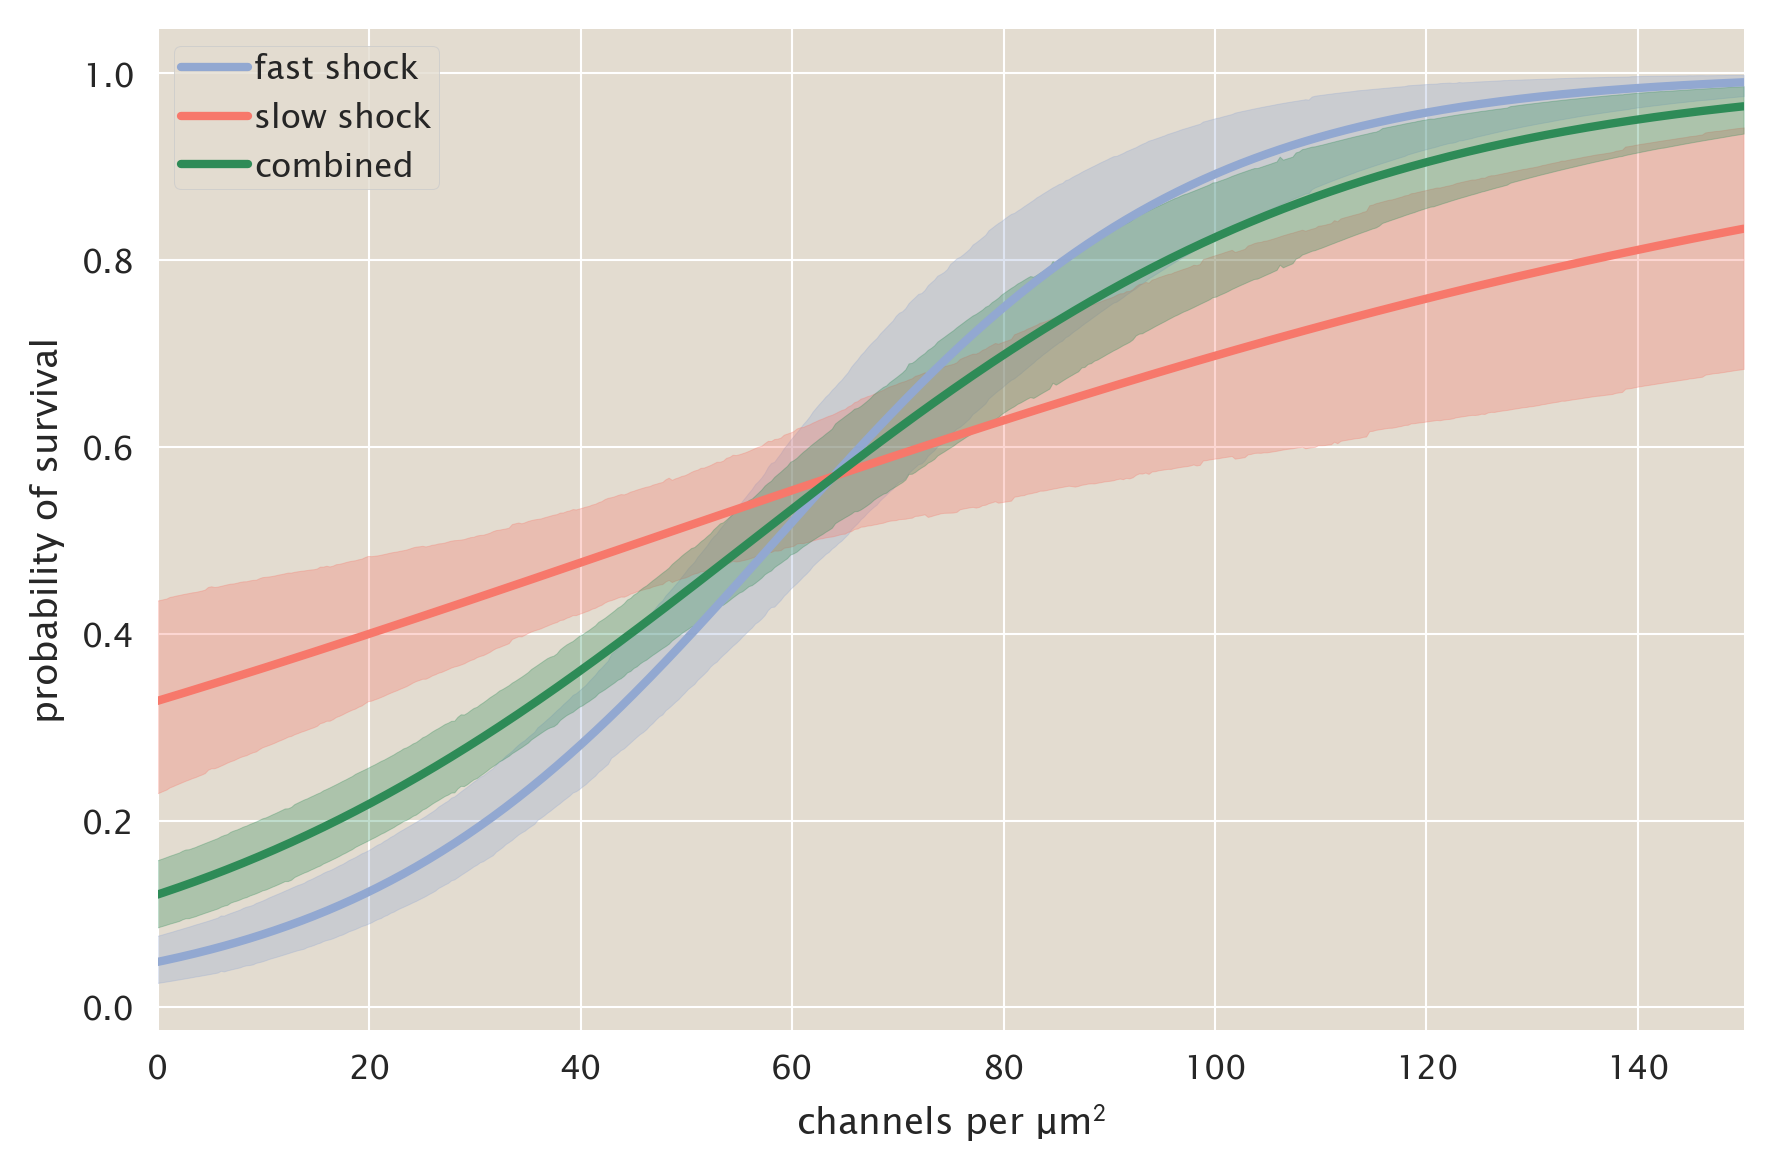

In [222]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xlabel('channels per μm$^2$')
ax.set_ylabel('probability of survival')
colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
for i, m in enumerate(modes):
    logit = m[0] + var * m[1]
    prob = (1 + np.exp(-logit))**-1
    ax.plot(var, prob, label='{0} shock'.format(group[i]),color=colors[group[i]])
    ax.fill_between(var, cred_regions[i][0, :], cred_regions[i][1, :], color=colors[group[i]], 
                   alpha=0.3, label='__nolegend__')
ax.plot(var, all_prob, color='seagreen', label='combined')
ax.fill_between(var, all_data_cred[0, :], all_data_cred[1, :], color='seagreen', alpha=0.3,
               label='__nolegend__')
ax.set_xlim([0, 150])
plt.legend()
plt.tight_layout()
plt.savefig('../figs/analysis/complete_logistic_regression.pdf', bbox_inches='tight')

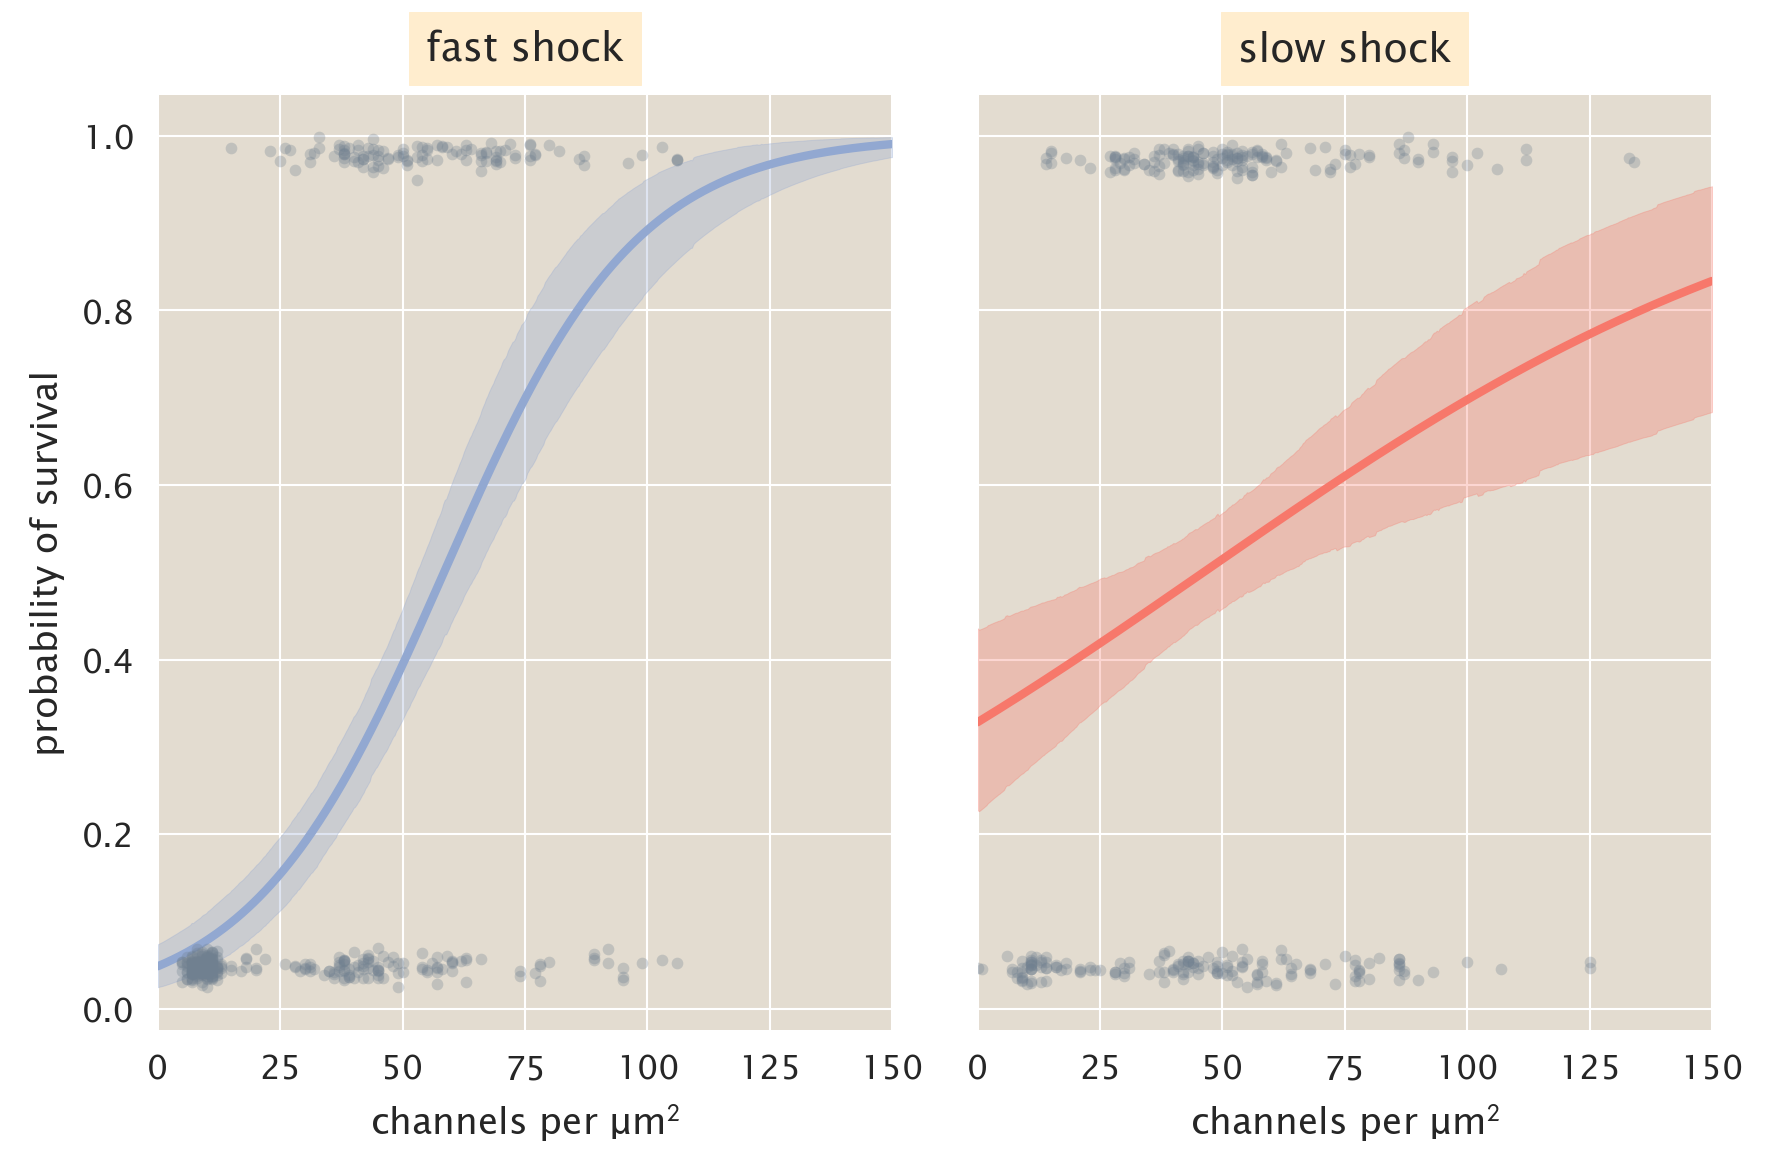

In [167]:
fig, ax = plt.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)

ax[0].set_ylabel('probability of survival')   
colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
axes = {'fast': ax[0], 'slow':ax[1]}
for i, m in enumerate(modes):
    logit = m[0] + var * m[1]
    prob = (1 + np.exp(-logit))**-1
    axes[group[i]].plot(var, prob, label='{0} shock'.format(group[i]),color=colors[group[i]])
    axes[group[i]].fill_between(var, cred_regions[i][0, :], cred_regions[i][1, :], color=colors[group[i]], 
                   alpha=0.3, label='__nolegend__', interpolate=True)

for g, d in grouped:
    ax2 = axes[g].twinx() 
    ax2.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)) - 0.5, '.',
             color='slategray', alpha=0.3)
    ax2.grid(False)
    ax2.set_yticks([])
 
ax[0].set_title('fast shock', backgroundcolor='#FFEDCE', y=1.01) 
ax[1].set_title('slow shock', backgroundcolor='#FFEDCE', y=1.01)

for a in ax:
    a.set_xlabel('channels per μm$^2$')

    a.set_xlim([0, 150])
plt.tight_layout()
plt.savefig('../figs/analysis/logistic_regression_shock_group_rugplot.pdf', bbox_inches='tight')